In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import geopandas as gpd
import itertools
import json
import matplotlib
import matplotlib.pyplot as plt
import osmnx as ox
import pandas as pd
import sys
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/home/chriscarey/miniconda3/envs/mlc/lib/python3.7/site-packages/geopandas/_compat.py:53: UserWarning: The installed version of PyGEOS is too old (0.5 installed, 0.8 required), and thus GeoPandas will not use PyGEOS.
  UserWarning,


In [3]:
CRS_LATLON = 'EPSG:4326'
DATA_DIR = '../../../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'
LIB_DIR = '../../lib'
LOG_DIR = '../../../log'

In [4]:
# Custom imports
sys.path.append(LIB_DIR)
from gtfs_sequence import Sequence

In [5]:
def peek(df):
    print(len(df))
    display(df.iloc[:3])

In [6]:
UNSUPPORTED_ROUTES = [
    'M35',
    'M60+',
]

# 1. Load Routes and Sequences

In [7]:
routes_gdf = gpd.read_file(
    f'{EXPORTS_DIR}/shp/manhattan/bus_routes_nyc_may2020.shp', crs=CRS_LATLON)
routes_gdf = routes_gdf.to_crs(CRS_LATLON)

# Remove unsupported routes.
routes_gdf = routes_gdf[~routes_gdf['route_id'].isin(UNSUPPORTED_ROUTES)]

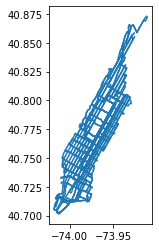

In [8]:
routes_gdf.plot()
plt.show()

In [9]:
# Load sequences from JSON and filter out unsupported routes.
sequence_dicts = []
with open(f'{EXPORTS_DIR}/json/manhattan/sequence_dicts.json', 'r') as fp:
    sequence_dicts = json.load(fp)
    
sequences = [
    Sequence(load_dict=load_dict)
    for load_dict in sequence_dicts
    if load_dict['route_id'] not in UNSUPPORTED_ROUTES
]

# 2. Aggregate Speeds Across Route Segments

In [10]:
speeds_gdfs = []

# Aggregate speeds across each route segment. Combine rows into a single
# GeoDataFrame for visualization with shared color scale.
for sequence in sequences:
    # Apply latest route geometries to each sequence.
    sequence.assign_route_geometry(routes_gdf)
    sequence.trim_route_geometry()
    
    # Aggregate speeds along sequence and combine with other sequences.
    sequence.aggregate_speeds()
    speeds_gdfs.append(sequence.get_speeds_gdf())
    
speeds_gdf = pd.concat(speeds_gdfs)

In [11]:
# Filter out invalid speeds.
MAX_SPEED_MPH = 60
MIN_SPEED_MPH = 0
SPEED_M_S_TO_MPH = 2.23694

# Convert to mph
speeds_gdf['end_value'] = speeds_gdf['end_value'] * SPEED_M_S_TO_MPH
speeds_gdf = speeds_gdf[speeds_gdf['end_value'] < MAX_SPEED_MPH]
speeds_gdf = speeds_gdf[speeds_gdf['end_value'] > MIN_SPEED_MPH]

# 3. Visualize Speeds By Route Segments

In [12]:
# Load Manhattan Road Network from OSMNX for background visualization.
road_mg = ox.load_graphml(f'{EXPORTS_DIR}/graphml/manhattan/road.graphml')

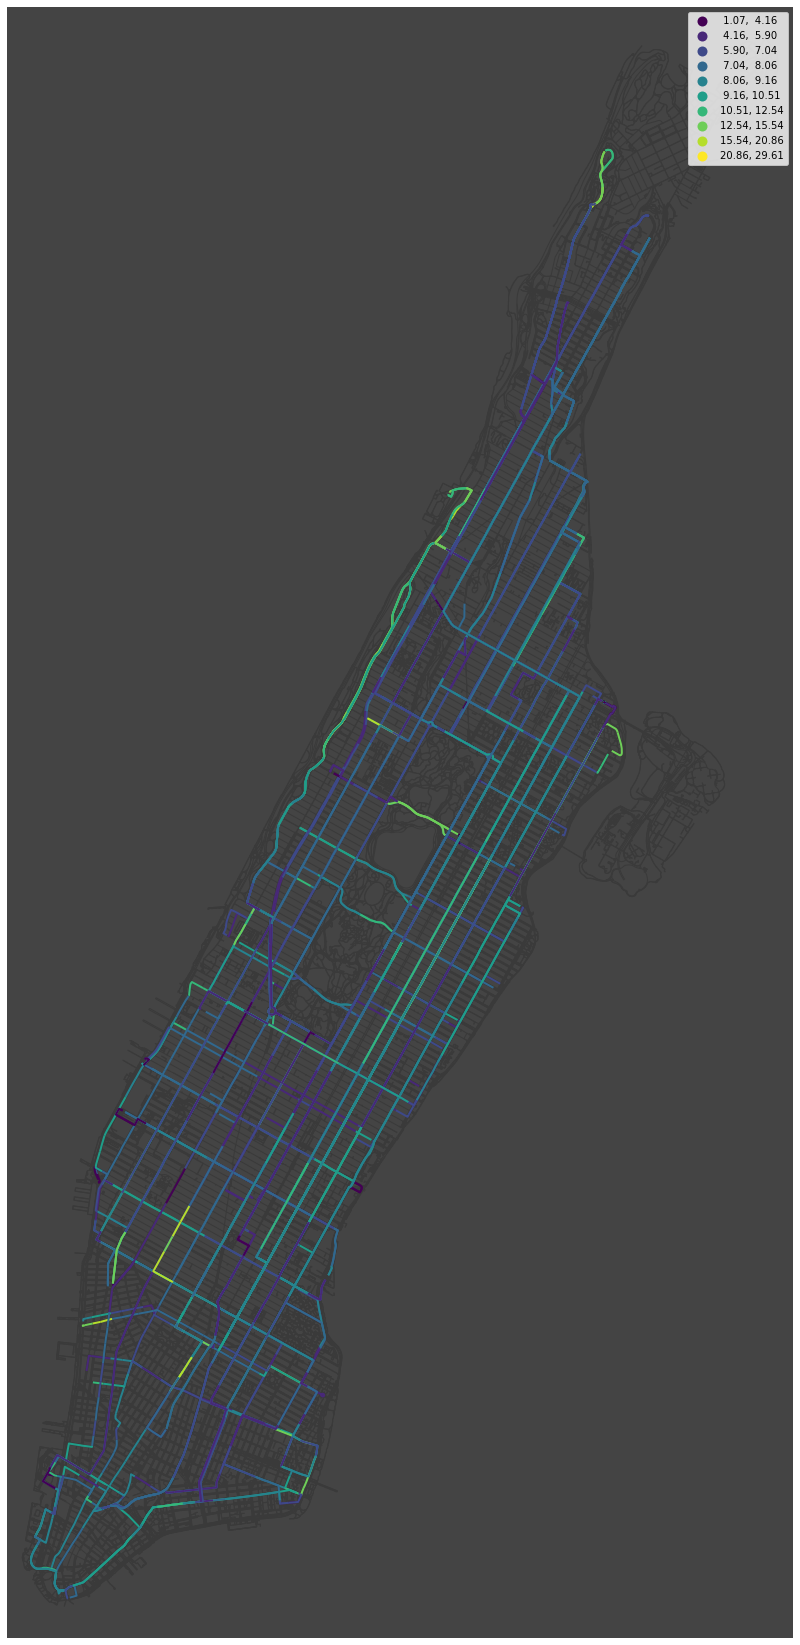

In [13]:
fig, ax = plt.subplots(figsize=(30, 30))

# Plot Manhattan road network.
ox.plot_graph(road_mg,
              ax=ax,
              bgcolor='#444',
              node_size=0,
              show=False,
              close=False,
              edge_color='#3a3a3a')

# Plot route segment speeds.
speeds_gdf.plot(ax=ax,
                column='end_value',
                zorder=1,
                k=10,
                scheme='FisherJenksSampled',
                linewidth=2,
                legend=True)

ax.set_facecolor('#444')
plt.show()